## STORM: 연구를 위한 멀티 에이전트

### 개요

STORM(Synthesis of Topic Outline through Retrieval and Multi-perspective Question Asking)은 Stanford 대학에서 개발한 LLM 기반의 지식 큐레이션 시스템입니다. 이 시스템은 인터넷 리서치를 통해 Wikipedia 수준의 포괄적이고 체계적인 장문의 기사를 자동으로 생성하는 것을 목표로 합니다.

![](https://github.com/stanford-oval/storm/raw/main/assets/two_stages.jpg)

### 핵심 아키텍처

STORM은 두 단계의 파이프라인으로 구성됩니다:

1. **사전 작성 단계(Pre-writing Stage)**
   - 인터넷 기반 리서치를 수행하여 참고 자료 수집
   - 다양한 관점(perspective) 발견
   - 주제에 대한 개요(outline) 생성

2. **작성 단계(Writing Stage)**
   - 생성된 개요와 수집된 참고 자료를 활용
   - 인용(citation)이 포함된 전체 기사 작성

### 멀티 에이전트 접근법

STORM의 핵심은 **관점 기반 질문 생성(Perspective-Guided Question Asking)** 과 **시뮬레이션된 대화(Simulated Conversation)** 전략입니다:

- **다양한 관점 발견**: 유사한 주제의 기존 기사들을 조사하여 다양한 시각을 발견하고, 이를 질문 생성 과정에 활용
- **역할 기반 대화 시뮬레이션**: Wikipedia 작성자와 주제 전문가 간의 대화를 시뮬레이션
  - 작성자 에이전트: 다양한 관점에서 질문 제기
  - 전문가 에이전트: 인터넷 소스에 기반한 답변 제공
  - 이를 통해 이해도를 업데이트하고 후속 질문 생성

### Co-STORM: 협업 확장

Co-STORM은 STORM을 협업 기능으로 확장한 버전으로, 다음과 같은 멀티 에이전트 구성을 포함합니다:


- **LLM 전문가 에이전트**: 외부 소스에 기반한 답변 생성 및 후속 질문 제기
- **중재자 에이전트(Moderator)**: 발견된 정보에서 영감을 받은 사고를 자극하는 질문 생성
- **동적 마인드맵**: 정보를 계층적으로 정리하여 인간과 시스템 간의 공유 개념 공간 생성

![](https://github.com/stanford-oval/storm/raw/main/assets/co-storm-workflow.jpg)

### 주요 특징

- **포괄적 커버리지**: 다양한 관점에서 주제를 탐색하여 Wikipedia 수준의 광범위한 내용 생성
- **구조화된 정보**: 자동으로 생성된 개요를 통해 체계적으로 정보 조직
- **신뢰할 수 있는 출처**: 인터넷 소스에 기반하여 모든 정보에 인용 포함
- **평가 검증**: FreshWiki 데이터셋을 통한 평가에서 기존 방법 대비 조직성 25%, 커버리지 10% 향상

STORM은 복잡한 연구 작업을 자동화하고, 다양한 관점에서 정보를 종합하며, 신뢰할 수 있는 장문의 리포트를 생성하는 멀티 에이전트 시스템의 우수한 사례입니다.

---

- 참고 자료: https://wikidocs.net/270693
- 관련 논문: https://arxiv.org/abs/2402.14207
- GitHub 저장소: https://github.com/stanford-oval/storm

## 환경 설정

In [3]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 분석가 생성 에이전트 with Human-In-The-Loop

분석가 생성이 필요한 클래스를 정의합니다.

In [4]:
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    """분석가 속성과 메타데이터를 정의"""

    affiliation: Annotated[str, Field(description="분석가의 주요 소속 기관")]
    name: Annotated[str, Field(description="분석가 이름")]
    role: Annotated[str, Field(description="주제 맥락에서의 분석가의 역할")]
    description: Annotated[
        str, Field(description="분석가의 관심사, 우려 사항 및 동기 설명")
    ]

    @property
    def persona(self) -> str:
        return (
            f"이름: {self.name}\n"
            f"역할: {self.role}\n"
            f"소속 기관: {self.affiliation}\n"
            f"설명: {self.description}\n"
        )


class Perspectives(BaseModel):
    """분석가들의 집합"""

    analysts: Annotated[
        list[Analyst],
        Field(description="분석가들의 역할 및 소속 기관을 포함한 종합 목록"),
    ]


### 분석가 생성 상태 및 노드 정의

In [5]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    topic: Annotated[str, "연구 주제"]
    max_analysts: Annotated[int, "생성할 분석가의 최대 수"]
    human_analyst_feedback: Annotated[str, "휴먼 피드백"]
    analysts: Annotated[list[Analyst], "분석가 목록"]

In [6]:
# 분석가 생성 프롬프트
analyst_instructions = """AI 분석가 페르소나 세트를 생성하는 임무를 맡았습니다.

다음 지침을 주의 깊게 따르십시오:

1. 먼저 연구 주제를 검토하십시오:
{topic}

2. 분석가 생성 가이드로 제공된 선택적 편집 피드백을 검토하십시오:
{human_analyst_feedback}

3. 위 문서 및/또는 피드백을 바탕으로 가장 흥미로운 테마를 결정하십시오.

4. 상위 {max_analysts}개 테마를 선정하십시오.

5. 각 테마에 한 명의 분석가를 배정하십시오."""

In [7]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage


llm = init_chat_model("openai:gpt-4.1-mini")


# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성합니다."""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    llm_with_structured = llm.with_structured_output(Perspectives)

    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    response = llm_with_structured.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    return {
        "analysts": response.analysts,
    }

In [8]:
create_analysts({"topic": "멀티 에이전트", "max_analysts": 3})

{'analysts': [Analyst(affiliation='MIT Computer Science and Artificial Intelligence Laboratory', name='Dr. Clara Zhang', role='Multi-Agent Systems Specialist', description='Dr. Zhang focuses on the coordination mechanisms in multi-agent systems, exploring how autonomous agents can collaborate effectively in dynamic environments to optimize collective outcomes.'),
  Analyst(affiliation='Stanford University, Department of Computer Science', name='Prof. Miguel Hernandez', role='Distributed AI Researcher', description='Prof. Hernandez researches decentralized algorithms that enable cooperation and negotiation among multiple agents, emphasizing scalability and robustness in complex multi-agent networks.'),
  Analyst(affiliation='DeepMind, Multi-Agent AI Group', name='Dr. Aisha Patel', role='Reinforcement Learning and Multi-Agent Interaction Analyst', description='Dr. Patel investigates reinforcement learning methods for multi-agent interaction, aiming to improve adaptive behaviors and emerg

In [9]:
# 사용자 피드백 노드
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass

### 분석가 생성 그래프 작성

In [10]:
from typing import Literal
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver


def should_continue(state: GenerateAnalystsState) -> Literal["create_analysts", END]:
    """워크플로우의 다음 노드를 결정합니다."""

    human_analyst_feedback = state.get("human_analyst_feedback", "")
    if human_analyst_feedback:
        return "create_analysts"
    return END


builder = StateGraph(GenerateAnalystsState)
builder.add_node(create_analysts)
builder.add_node(human_feedback)

builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", should_continue, {"create_analysts": "create_analysts", END: END}
)
builder.set_entry_point("create_analysts")
graph = builder.compile(
    interrupt_before=["human_feedback"], checkpointer=InMemorySaver()
)


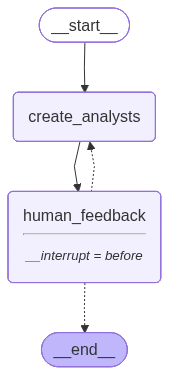

In [11]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### 분석가 생성 그래프 실행

In [12]:
from pprint import pprint
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(configurable={"thread_id": random()})

inputs = {
    "max_analysts": 3,
    "topic": "Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?",
}
for event in graph.stream(inputs, config=config):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)



##### create_analysts #####
{'analysts': [Analyst(affiliation='TechInsights Research Institute', name='Dr. Hana Kim', role='AI Research Analyst', description='Dr. Hana Kim specializes in artificial intelligence methodologies with a focus on retrieval-augmented generation techniques. She analyzes the distinctions between agentic and adaptive RAG, emphasizing how agentic RAG involves autonomous agent-driven data retrieval and synthesis, whereas adaptive RAG adapts the retrieval process dynamically based on context and model feedback.'),
              Analyst(affiliation='NextGen AI Solutions', name='Jinsoo Park', role='Machine Learning Engineer and Analyst', description='Jinsoo Park explores practical implementations of RAG frameworks in industry settings. His analysis highlights the differences such as agentic RAG enabling agents to perform goal-directed retrieval autonomously, contrasting with adaptive RAG’s capacity to dynamically adjust retrieval strategies to optimize output releva

In [13]:
# 현재 상태 스냅샷
snapshot = graph.get_state(config)
pprint(snapshot.values)
pprint(snapshot.next)

{'analysts': [Analyst(affiliation='TechInsights Research Institute', name='Dr. Hana Kim', role='AI Research Analyst', description='Dr. Hana Kim specializes in artificial intelligence methodologies with a focus on retrieval-augmented generation techniques. She analyzes the distinctions between agentic and adaptive RAG, emphasizing how agentic RAG involves autonomous agent-driven data retrieval and synthesis, whereas adaptive RAG adapts the retrieval process dynamically based on context and model feedback.'),
              Analyst(affiliation='NextGen AI Solutions', name='Jinsoo Park', role='Machine Learning Engineer and Analyst', description='Jinsoo Park explores practical implementations of RAG frameworks in industry settings. His analysis highlights the differences such as agentic RAG enabling agents to perform goal-directed retrieval autonomously, contrasting with adaptive RAG’s capacity to dynamically adjust retrieval strategies to optimize output relevance and accuracy.'),
        

In [14]:
# 휴먼 피드백 전달
from langgraph.types import Command

for event in graph.stream(
    Command(
        update={
            "human_analyst_feedback": "스타트업 출신의 석호필이라는 인물을 추가해 기업가적 관점을 더해주세요."
        },
    ),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None

##### create_analysts #####
{'analysts': [Analyst(affiliation='TechStart Ventures', name='석호필', role='AI Entrepreneur and Analyst', description='스타트업 출신의 석호필은 Agentic RAG와 Adaptive RAG의 차이점을 기업가적 관점에서 분석하며, 각각의 접근법이 실제 서비스 개발과 혁신에 미치는 영향을 탐구한다.'),
              Analyst(affiliation='AI Research Institute', name='김유정', role='Machine Learning Researcher', description='AI 연구원 김유정은 Agentic RAG와 Adaptive RAG의 기술적 특성과 작동 메커니즘의 차이를 중심으로 분석한다.'),
              Analyst(affiliation='Digital Innovation Lab', name='이준서', role='Systems Analyst', description='시스템 애널리스트 이준서는 Agentic RAG와 Adaptive RAG의 시스템 통합 및 적용 사례를 비교하며 실용적 측면을 평가한다.')]}

##### __interrupt__ #####
()


In [15]:
for event in graph.stream(
    Command(update={"human_analyst_feedback": None}),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None


최종 결과를 출력합니다.

In [16]:
# 스냅샷을 가져옵니다.
final_state = graph.get_state(config)
pprint(final_state)

StateSnapshot(values={'topic': 'Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?', 'max_analysts': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='TechStart Ventures', name='석호필', role='AI Entrepreneur and Analyst', description='스타트업 출신의 석호필은 Agentic RAG와 Adaptive RAG의 차이점을 기업가적 관점에서 분석하며, 각각의 접근법이 실제 서비스 개발과 혁신에 미치는 영향을 탐구한다.'), Analyst(affiliation='AI Research Institute', name='김유정', role='Machine Learning Researcher', description='AI 연구원 김유정은 Agentic RAG와 Adaptive RAG의 기술적 특성과 작동 메커니즘의 차이를 중심으로 분석한다.'), Analyst(affiliation='Digital Innovation Lab', name='이준서', role='Systems Analyst', description='시스템 애널리스트 이준서는 Agentic RAG와 Adaptive RAG의 시스템 통합 및 적용 사례를 비교하며 실용적 측면을 평가한다.')]}, next=(), config={'configurable': {'thread_id': '0.9239488424970229', 'checkpoint_ns': '', 'checkpoint_id': '1f0abcad-babc-641e-8004-ee02e8be0e12'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-10-18T02:33:40.569597+00:00', parent_config={'configurable': {'thread_id': '0.9

In [17]:
analysts = final_state.values.get("analysts")
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

생성된 분석가 수: 3
이름: 석호필
역할: AI Entrepreneur and Analyst
소속 기관: TechStart Ventures
설명: 스타트업 출신의 석호필은 Agentic RAG와 Adaptive RAG의 차이점을 기업가적 관점에서 분석하며, 각각의 접근법이 실제 서비스 개발과 혁신에 미치는 영향을 탐구한다.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: 김유정
역할: Machine Learning Researcher
소속 기관: AI Research Institute
설명: AI 연구원 김유정은 Agentic RAG와 Adaptive RAG의 기술적 특성과 작동 메커니즘의 차이를 중심으로 분석한다.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: 이준서
역할: Systems Analyst
소속 기관: Digital Innovation Lab
설명: 시스템 애널리스트 이준서는 Agentic RAG와 Adaptive RAG의 시스템 통합 및 적용 사례를 비교하며 실용적 측면을 평가한다.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


## 인터뷰 에이전트

### 질문 생성 노드

In [104]:
import operator
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    """인터뷰 정보를 저장합니다."""

    topic: Annotated[str, "연구 주제"]
    max_num: Annotated[int, "대화 턴수"]
    context: Annotated[list, operator.add]
    analyst: Annotated[Analyst, "분석가"]
    interview: Annotated[str, "인터뷰 내용"]
    sections: Annotated[list, operator.add, "보고서 섹션 목록"]


class SearchQuery(BaseModel):
    search_query: Annotated[str, Field(None, description="retrieval를 위한 검색 쿼리")]

In [105]:
# 인터뷰 시스템 프롬프트
question_instructions = """당신은 특정 주제에 대해 알아보기 위해 전문가를 인터뷰하는 임무를 맡은 분석가입니다.

당신의 목표는 주제에 관련된 흥미롭고 구체적인 통찰력을 추출하는 것입니다.

1. 흥미로움: 사람들이 놀라워하거나 당연하지 않다고 느낄 만한 통찰력.
2. 구체성: 일반론을 피하고 전문가의 구체적인 사례를 포함하는 통찰력.

다음은 집중할 주제입니다:
{topic}

첫 대화를 시작할때에 당신의 인물을 반영하는 이름으로 자신을 소개한 후 질문을 시작하세요.

주제에 대한 이해를 심화하고 정교화하기 위해 계속해서 질문을 이어가세요.

이해가 충분하다고 판단되면 "도움 주셔서 정말 감사합니다!"라고 말하며 인터뷰를 마무리하세요.

응답 전반에 걸쳐 제공된 인물과 목표를 반영하여 캐릭터를 유지하는 것을 잊지 마세요.

<Persona>
{persona}
<Persona>
"""

In [106]:
# 질문 생성 노드
def generate_question(state: InterviewState):
    """통찰력있는 질문을 생성합니다."""
    analyst = state["analyst"]

    system_message = question_instructions.format(
        topic="Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점",
        persona=analyst.persona,
    )
    response = llm.invoke([SystemMessage(content=system_message)] + state["messages"])
    response.name = "분석가"

    return {"messages": [response]}

In [107]:
analyst = Analyst(
    name="김필",
    affiliation="Tech Innovators Inc.",
    role="기업가적 분석가",
    description="창업자 출신 분석가로, 기업가 정신과 비즈니스 모델 혁신에 주력합니다. 스타트업 관점에서 적응형 시스템에 대한 통찰력을 제공하며, 유연성과 시장 적응력을 강조합니다.",
)
response = generate_question(
    {
        "analyst": analyst,
        "messages": [],
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Name: 분석가

안녕하세요, 김필입니다. 스타트업과 신기술 혁신에 늘 관심이 많아서, 오늘은 Modular RAG와 기존 Naive RAG의 차이점 그리고 실제 프로덕션 레벨에서 Modular RAG를 사용하는 구체적인 이점에 대해 깊게 알아보고 싶습니다. 

먼저, 두 방식 간의 핵심적인 구조적 차이나 처리 방식에서 가장 눈에 띄는 차이가 무엇인지 현장에서 자주 접하는 사례를 들어 설명해 주실 수 있을까요?


### 도구 정의

#### 웹검색 도구

In [108]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

In [109]:
web_search.invoke({"query": "지난 윔블던에서 무슨 일이 있었나요?"})

{'query': '지난 윔블던에서 무슨 일이 있었나요?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.chosun.com/sports/sports_general/2025/07/13/WL5WE45CLBEGTISJHNMPNE3CXE/',
   'title': '“윔블던에 베이글 가게 오픈”… 시비옹테크 여자단식 결승서 진기록',
   'content': '테니스 메이저 대회 윔블던 챔피언십 결승에서 1968년 오픈 시대 개막 이후 처음으로 ‘더블 베이글’이 나왔다. 이가 시비옹테크(4위·폴란드)와 어맨다 아니시모바(12위·미국)의 12일(현지 시각) 여자 단식 최종전. 지난 준결승에서 세계 1위 아리나 사발렌카(벨라루스)를 2대1로 꺾고 생애 첫 메이저 대회 결승에 안착한 아니시모바였지만 결과는 허무했다. 한편 올해 윔블던 남자 단식에서는 각각 세계 1·2위인 얀니크 신네르(이탈리아), 카를로스 알카라스(스페인)의 빅 매치가 성사됐다. 쟁쟁한 신예 사이 준결승에까지 오른 ‘노장’ 노바크 조코비치(6위·세르비아)는 11일 신네르와 준결승에서 0대3 완패했다. 얀니크 신네르(세계 1위·이탈리아)와 노바크 조코비치(6위·세르비아), 카를로스 알카라스(2위·스페인)와 테일러 프리츠(5위·미국)가 윔블던 결... 조코비치는 지난 5일 영국 런던 올잉글랜드 클럽에서 열린 윔블던 챔피언십... ‘베컴 조항’을 품은 손흥민(33, LAFC)을 향해 유럽 클럽들의 임대 영입 경쟁이 본격화될 것으로 보인다. 지난 20년간 윔블던 남자단식 우승한 사람이 꼴랑 5명인데 여자는 지난 10년간 10명..',
   'score': 0.39733082,
   'raw_content': None},
  {'url': 'http://m.tennispeople.kr/news/articleView.html?idxno=17168',
   'title': '윔블던 컴퓨터 라

#### 논문 검색 도구

In [110]:
from langchain_community.retrievers import ArxivRetriever

arxiv_retriever = ArxivRetriever(
    load_max_docs=3,
    load_all_available_meta=True,
    get_full_documents=True,
)

In [111]:
arxiv_retriever.invoke("Modular RAG vs Naive RAG")

[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

### 노드 작성

#### 웹 검색 노드

In [112]:
# 검색 쿼리 변환 프롬프트
search_instructions = """분석가와 전문가 간의 대화가 제시됩니다.

목표는 해당 대화와 관련된 검색 및/또는 웹 검색에 사용할 잘 구조화된 쿼리를 생성하는 것입니다.

먼저 전체 대화를 분석하십시오.

특히 분석가가 마지막에 제기한 질문에 주목하십시오.

이 마지막 질문을 잘 구조화된 웹 검색 쿼리로 변환하십시오."""


def search_web(state: InterviewState):
    """웹 검색을 통한 문서 검색"""

    llm_with_structured = llm.with_structured_output(SearchQuery)

    response = llm_with_structured.invoke(
        [("system", search_instructions)] + state["messages"]
    )

    results = web_search.invoke(response.search_query)
    context = [
        f'<Document source="web" url="{doc["url"]}" title="{doc["title"]}">{doc["content"]}</Document>'
        for doc in results["results"]
    ]

    return {"context": [*context]}


In [113]:
search_web({"messages": [("user", "CRAG에 대해서 설명해주세요.")]})

{'context': ['<Document source="web" url="https://www.meilisearch.com/blog/corrective-rag" title="Corrective RAG (CRAG): Workflow, implementation, and more"># Corrective RAG (CRAG): Workflow, implementation, and more Learn what Corrective RAG (CRAG) is, how it works, how to implement it, and why it improves accuracy in retrieval-augmented generation workflows. What is corrective RAG (CRAG)? Instead of allowing irrelevant or weak context to enter your large language model (LLM) pipeline, CRAG performs checks and corrections, resulting in sharper, faster, and more trustworthy answers. ## What is corrective RAG (CRAG)? Corrective retrieval-augmented generation, or CRAG, is a type of RAG-based approach used to improve the reliability of AI-generated answers. Instead of simply passing retrieved documents to a language model without any adjustments, CRAG introduces an additional step – it evaluates, filters, and refines the retrieved information before an answer is generated.</Document>',
  

#### 논문 검색 노드

In [114]:
def search_arxiv(state: InterviewState):
    """Arxiv 검색 노드"""

    llm_with_structured = llm.with_structured_output(SearchQuery)

    response = llm_with_structured.invoke(
        [("system", search_instructions)] + state["messages"]
    )

    results = arxiv_retriever.invoke(
        response.search_query,
        load_max_docs=2,
        load_all_available_meta=True,
        get_full_documents=False,
    )

    context = [
        f'<Document source="arxiv" url="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in results
    ]

    return {"context": [*context]}


In [115]:
search_arxiv({"messages": [("user", "CRAG에 대해서 설명해주세요.")]})

{'context': ['<Document source="arxiv" url="http://arxiv.org/abs/2502.19629v1" date="2025-02-26" authors="Tiffany J. Callahan, Nathaniel H. Park, Sara Capponi"/>\n<Title>\nAgentic Mixture-of-Workflows for Multi-Modal Chemical Search\n</Title>\n\n<Summary>\nThe vast and complex materials design space demands innovative strategies to\nintegrate multidisciplinary scientific knowledge and optimize materials\ndiscovery. While large language models (LLMs) have demonstrated promising\nreasoning and automation capabilities across various domains, their application\nin materials science remains limited due to a lack of benchmarking standards\nand practical implementation frameworks. To address these challenges, we\nintroduce Mixture-of-Workflows for Self-Corrective Retrieval-Augmented\nGeneration (CRAG-MoW) - a novel paradigm that orchestrates multiple agentic\nworkflows employing distinct CRAG strategies using open-source LLMs. Unlike\nprior approaches, CRAG-MoW synthesizes diverse outputs thr

#### 답변 생성 노드

In [116]:
answer_instructions = """당신은 분석가에게 인터뷰를 받는 전문가입니다.

분석가의 주요 관심 분야는 다음과 같습니다: {goals}. 

당신의 목표는 분석가가 제기한 질문에 답변하는 것입니다.

질문에 답변할 때는 다음 맥락을 활용하십시오:
<Context>
{context}
<Context>

질문에 답변할 때는 다음 지침을 따르십시오:
1. 맥락에 제공된 정보만 사용하십시오. 
2. 외부 정보를 도입하거나 맥락에 명시적으로 언급된 내용을 넘어선 추측을 하지 마십시오.
3. 맥락에는 각 개별 문서의 주제별 출처가 포함되어 있습니다.
4. 답변에서 관련 진술 옆에 해당 출처를 포함하십시오. 예를 들어 출처 #1의 경우 [1]을 사용하십시오.
5. 답변 하단에 출처를 순서대로 나열하십시오. [1] 출처 1, [2] 출처 2, 등
6. 출처가 다음과 같은 경우: <Document url="assistant/docs/llama3_1.pdf" page="7" />' 
    다음처럼 기재하십시오: [1] assistant/docs/llama3_1.pdf, 7 페이지
7. 제공된 맥락이 없다면 출처를 기재하기 마십시오.
    
인용 시 괄호 추가 및 Document 서두 문구는 생략하십시오."""


def generate_answer(state: InterviewState):
    """질문에 대한 답변 노드"""

    analyst = state["analyst"]

    system_message = answer_instructions.format(
        goals=analyst.description,
        context="\n".join(state["context"]),
    )
    response = llm.invoke([("system", system_message)] + state["messages"])
    response.name = "전문가"

    return {"messages": [response]}

In [117]:
from langchain_core.messages import HumanMessage

response = generate_answer(
    {
        "analyst": analyst,
        "context": [],
        "messages": [
            HumanMessage(
                content="Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점",
                name="분석가",
            )
        ],
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Name: 전문가

Modular RAG와 기존의 Naive RAG의 차이점은 다음과 같습니다.

Naive RAG는 Retrieval-Augmented Generation의 기본 형태로, 문서 검색과 생성 모델이 하나의 통합된 파이프라인 내에서 밀접하게 결합되어 작동합니다. 이는 단일 시스템에서 검색 및 생성을 처리하는 단순한 구조를 의미합니다.

반면, Modular RAG는 구성 요소들을 모듈화하여 분리된 시스템으로 운영합니다. 각 모듈은 독립적으로 개발, 개선, 교체가 가능하며, 이를 통해 시스템의 유연성과 확장성을 크게 향상시킵니다. 즉, 검색 모듈과 생성 모듈을 별도로 최적화하고 필요에 따라 교체할 수 있어, 전체 파이프라인의 효율성과 적응성을 높입니다.

Production level에서 Modular RAG를 사용하는 이점은 다음과 같습니다.

1. 유연성: 모듈 단위로 개선 가능하므로, 새로운 검색 알고리즘이나 생성 모델을 쉽게 도입할 수 있습니다.
2. 유지보수 용이성: 개별 모듈만 업데이트하거나 수정하면 되기 때문에, 운영 중인 시스템에 미치는 영향이 최소화됩니다.
3. 확장성: 변화하는 시장 요구나 데이터 환경에 빠르게 대응할 수 있으며, 시스템 확장이 용이합니다.

따라서, Modular RAG는 기존 Naive RAG에 비해 스타트업이나 빠르게 변화하는 비즈니스 환경에서 시장 적응력과 혁신을 촉진하는 데 더욱 적합한 시스템 설계 접근법입니다. 이는 창업자 출신 분석가들이 강조하는 유연성과 적응성 측면에서 큰 장점을 제공합니다.


### 문석 작성 노드

In [118]:
# 기술 문서 작성 프롬프트
section_writer_instructions = """당신은 전문 기술 문서 작성자입니다.

당신의 임무는 일련의 원본 문서를 철저히 분석하여 보고서의 상세하고 포괄적인 섹션을 작성하는 것입니다.
이는 핵심 통찰력을 추출하고, 관련 사항을 상세히 설명하며, 명확성과 이해를 보장하기 위한 심층적인 해설을 제공하는 것을 포함합니다. 필요한 배경 정보, 뒷받침하는 증거, 예시를 포함하여 독자의 이해를 높여야 합니다. 논리적이고 체계적인 구조를 유지하며, 모든 핵심 사항이 상세히 다루어지고 전문적인 어조로 제시되도록 하십시오.

다음 지침을 따르십시오:
1. 원본 문서의 내용 분석:
- 각 원본 문서의 이름은 문서 시작 부분에 <Document> 태그와 함께 기재되어 있습니다.

2. 마크다운 서식을 사용하여 보고서 구조 생성:
- 섹션 제목에는 ## 사용
- 하위 섹션 헤더에는 ### 사용

3. 다음 구조에 따라 보고서 작성:
a. 제목 (## 헤더)
b. 요약 (### 헤더)
c. 종합 분석 (### 헤더)
d. 출처 (### 헤더)

4. 분석가의 중점 분야를 반영하여 제목을 흥미롭게 작성하십시오: 
{focus}

5. 요약 섹션 작성 시:
- 분석가의 중점 분야와 관련된 일반적 배경/맥락을 요약으로 제시하십시오
- 인터뷰에서 수집한 통찰 중 새롭거나 흥미롭거나 놀라운 점을 강조하십시오
- 사용한 출처 문서를 번호 매긴 목록으로 작성하십시오
- 인터뷰어 또는 전문가의 이름은 언급하지 마십시오
- 최대 약 400단어를 목표로 하십시오
- 출처 문서의 정보에 기반하여 보고서에서 번호 매긴 출처([1], [2] 등)를 사용하십시오

6. 종합 분석 섹션:
- 출처 문서의 정보를 상세히 검토하십시오.
- 복잡한 아이디어를 이해하기 쉬운 단위로 분해하고 논리적인 흐름을 유지하십시오.
- 분석의 다양한 관점이나 차원을 다루기 위해 필요한 경우 하위 섹션을 사용하십시오.
- 원본 문서의 데이터, 직접 인용문, 예시를 통해 분석을 뒷받침하십시오.
- 각 논점이 보고서의 전반적인 초점과 어떻게 관련되는지 명확히 설명하십시오.
- 여러 관련 아이디어를 제시할 때는 명확성을 위해 글머리 기호나 번호 매기기 목록을 사용하십시오.
- 전문적이고 객관적인 어조를 유지하며 편향되거나 근거 없는 의견을 피하십시오.
- 분석이 철저하도록 최소 800단어를 목표로 하십시오.

7. 출처 섹션에서:
- 보고서에 사용된 모든 출처를 포함하십시오
- 관련 웹사이트 또는 특정 문서 경로의 전체 링크를 제공하십시오
- 각 출처는 새 줄로 구분하십시오. 마크다운에서 새 줄을 만들기 위해 각 줄 끝에 두 개의 공백을 사용하십시오.
- 예시:
    ### 출처
    [1] 링크 또는 문서명
    [2] 링크 또는 문서명

8. 출처를 반드시 통합하십시오. 예를 들어 다음은 올바르지 않습니다:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

중복 출처는 없어야 합니다. 다음과 같이 간결하게 작성하십시오:

[3] https://ai.meta.com/blog/meta-llama-3-1/

9. 최종 검토:
- 보고서가 요구되는 구조를 따르는지 확인하십시오.
- 보고서 제목 앞에 서문을 포함하지 마십시오.
- 모든 지침이 준수되었는지 확인하십시오.
"""

from langchain_core.messages import get_buffer_string


def write_section(state: InterviewState):
    """인터뷰에 대한 리포트 작성"""

    analyst = state["analyst"]

    # 인터뷰를 문자열로 변환
    interview = get_buffer_string(state["messages"])

    # 섹션 작성을 위한 시스템 프롬프트 정의
    system_message = section_writer_instructions.format(focus=analyst.description)
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [
            HumanMessage(
                content=f"분석가와 전문가의 인터뷰 내용입니다:\n<Interview>\n{interview}\n</Interview>"
            ),
            HumanMessage(
                content=f"이 자료를 사용하여 해당 섹션을 작성하십시오:\n<Resources>\n{state['context']}\n</Resources>"
            ),
        ]
    )
    return {"sections": [response.content]}

### 인터뷰 그래프 작성

In [132]:
from langchain_core.messages import AIMessage


def should_continue_interview(state: InterviewState) -> Literal["finish", "continue"]:
    """인터뷰를 계속 진행할 지 여부를 판단합니다."""

    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    expert_message_count = sum(
        1 for m in messages if isinstance(m, AIMessage) and m.name == "전문가"
    )

    # 전문가가 최대 턴 이상 답변했다면 인터뷰를 종료합니다.
    if expert_message_count >= max_num_turns:
        return "finish"

    last_message = messages[-1]
    if "도움 주셔서 정말 감사합니다" in last_message.content:
        return "finish"

    return "continue"


class InterviewOutputState(TypedDict):
    """서브그래프가 부모로 반환할 상태"""

    analyst: Annotated[Analyst, "분석가"]
    sections: Annotated[list, operator.add, "보고서 섹션 목록"]


interview_builder = StateGraph(InterviewState, output_schema=InterviewOutputState)
interview_builder.add_node(generate_question)  # 질문 생성
interview_builder.add_node(search_web)  # 웹 검색
interview_builder.add_node(search_arxiv)  # arxiv 검색
interview_builder.add_node(generate_answer)  # 답변 생성
interview_builder.add_node(write_section)  # 문서 작성

interview_builder.set_entry_point("generate_question")
interview_builder.add_edge("generate_question", "search_web")
interview_builder.add_edge("generate_question", "search_arxiv")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_arxiv", "generate_answer")
interview_builder.add_conditional_edges(
    "generate_answer",
    should_continue_interview,
    {
        "continue": "generate_question",
        "finish": "write_section",
    },
)
interview_builder.set_finish_point("write_section")

interview_graph = interview_builder.compile(
    checkpointer=InMemorySaver(),
).with_config(run_name="Conduct Interviews")


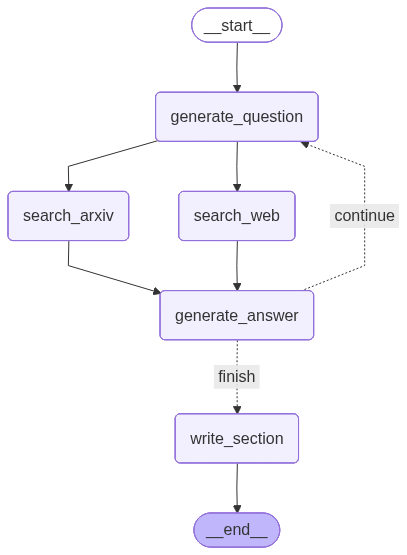

In [133]:
from IPython.display import display, Image

display(Image(interview_graph.get_graph().draw_mermaid_png()))

### 인터뷰 그래프 실행

In [134]:
from langchain_teddynote.messages import invoke_graph


config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random()},
)

topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 그래프 실행
invoke_graph(
    interview_graph,
    {
        "topic": topic,
        "analyst": analysts[0],
        "messages": [
            (
                "user",
                f'그래서 당신이 이 주제에 대해서 글을 쓰고 있다고 했죠? 라고 말씀하셨죠? "{topic}"',
            )
        ],
        "max_num_turns": 2,
    },
    config=config,
    node_names=["generate_question", "generate_answer", "write_section"],
)



🔄 Node: generate_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Name: 분석가

안녕하세요, 저는 TechStart Ventures에서 AI 분야를 분석하고 스타트업 생태계에 혁신을 가져오는 일을 하는 석호필입니다. 오늘은 Modular RAG와 Naive RAG의 차이점, 그리고 이를 프로덕션 레벨에서 사용할 때 어떤 이점이 있는지 깊이 파고들고자 합니다.

먼저, 석호필 입장에서 Naive RAG와 Modular RAG를 비교해볼 때, 가장 큰 차이는 시스템의 구성 방식과 유연성에 있다고 봅니다. 혹시 석호필이 파악한 바와 실제 현장에서의 적용 사례 중에서, Modular RAG가 구조적인 측면에서 어떤 차별화된 유연성을 제공하는지를 구체적으로 설명해 주실 수 있나요?

🔄 Node: generate_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Name: 전문가

네, 석호필님께서 짚어주신 대로 Modular RAG와 Naive RAG의 핵심 차이는 아키텍처의 유연성과 모듈화에 있습니다. Naive RAG는 기본적으로 문서 검색과 그 결과를 바탕으로 생성하는 단일 흐름 형태의 모놀리식 구조로, 검색이 정적이고 제한적입니다. 이로 인해 검색 효율이 떨어지고, 생성 모델과의 긴밀한 통합이 어렵다는 단점이 있습니다.

반면 Modular RAG는 검색과 생성을 각각 독립적인 모듈로 분리하여 설계되며, 각 모듈은 쉽게 교체하거나 업그레이드할 수 있습니다. 이로 인해 다양한 검색 알고리즘, 재순위화 전략, 생성 모델 등과 유연하게 조합할 

In [135]:
from IPython.display import Markdown, display

snapshot = interview_graph.get_state(config=config)
display(Markdown(snapshot.values["sections"][0]))

## 스타트업 출신 석호필의 기업가 관점에서 본 Agentic RAG와 Adaptive RAG의 차이 및 실제 서비스 혁신에 미치는 영향

### 요약

Retrieval-Augmented Generation(RAG)은 대규모 언어 모델(LLM)의 한계를 극복하기 위해 외부 지식원을 동적으로 참조하는 기술로, 지식 집약적 업무에서의 정확성과 신뢰성을 크게 향상시켰다[9]. RAG에는 Naive RAG, Adaptive RAG, Modular RAG 등 발전된 여러 패러다임이 존재하는데, 이 중 Modular RAG는 Naive RAG 대비 유연성과 재구성성이 뛰어나, 스타트업 환경에서 빠른 프로토타이핑과 지속적 개선에 적합하다[4]. 특히 실제 프로덕션 환경에서는 각 모듈의 독립적 업데이트와 장애 격리가 가능해 운영 안정성과 확장성을 극대화한다[4][7]. Vendi-RAG와 같은 Adaptive RAG 계열은 질의별로 관련 문서들의 다양성과 품질을 적응적으로 조절함으로써 다단계 추론 정확도를 크게 끌어올리며, GPT-4 등 다양한 LLM 백본에 일관된 성능 향상을 보여 최신 영역에서 각광받고 있다[1]. 이러한 기술적 진화를 바탕으로, Agentic RAG는 다중 RAG 파이프라인 및 모듈을 조합해 복합적 작업에 대응하고 스타트업이 다양한 시나리오에 맞춤형 RAG를 적용하여 혁신적인 서비스 개발을 가능케 한다[2]. 석호필이 강조한 점은 Modular RAG의 구조적 유연성과 운영상의 민첩함이 단순한 성능 향상을 넘어 실제 산업 현장에서 스타트업들의 경쟁력 확보와 혁신 가속화에 필수적인 요소라는 것이다[4][7]. 본 분석은 석호필의 기업가적 시각과 인터뷰 내용을 중심으로 이러한 RAG 모델들의 실질적 차별성과 적용 이점을 다각도로 조명하였다. 

출처 문서:  
[1] arXiv:2502.11228v2 - Vendi-RAG 논문  
[2] arXiv:2508.13828v1 - Multi-RAG 시스템 협업 연구  
[4] arXiv:2407.21059v1 - Modular RAG 프레임워크  
[7] 인터뷰 전문  

---

### 종합 분석

#### 1. Naive RAG와 Modular RAG: 구조와 유연성의 차이

*Naive RAG*는 전통적 RAG 패러다임의 기본 형태로, 정적이고 단일 흐름의 모놀리식 시스템이다. 이 구조 내에서 문서 검색(retrieval)과 생성(generation) 모듈은 밀접하게 결합되어 있어, 검색 효율 저하나 장애가 발생하면 전체 시스템 성능에 영향을 끼친다[4][웹자료]. 검색은 주로 단순 유사도 기반이며, 결과 문서들의 중복과 잡음이 많아 LLM이 핵심 정보를 효율적으로 추출하기 어렵다[4][9]. 또한, Naive RAG는 모듈별 교체가 어렵고, 프로덕션 환경에서 특정 기능 업데이트 시 전체 시스템을 재배포해야 하는 단점이 있다.

이에 반해 *Modular RAG*는 Lego 블록처럼 독립적이고 교체 가능한 모듈들로 시스템을 분해하며, 검색 모듈, 생성 모듈, 재순위화 모듈 등이 명확히 분리되어 있다[4]. 이런 모듈화 설계는 다음과 같은 이점을 제공한다:

- **유연성** : 다양한 검색 알고리즘이나 생성 모델을 교체, 조합 가능하며, 각 모듈을 최적화할 수 있다.
- **확장성** : 서비스 고도화 시 필요한 기능을 모듈 단위로 추가하거나 변경하면서 시스템을 확장한다.
- **운영 효율성** : 장애 발생 시 해당 모듈만 롤백, 교체 가능해 서비스 중단 최소화가 가능하다.
- **실험적 조합 용이** : 다양한 검색 및 생성 조합을 빠르게 실험해 최적 성능을 도출할 수 있다[4][7][웹자료].

석호필은 스타트업 환경에서의 이러한 모듈러 접근법이 빠른 반복과 변화 대응에 적합하며, 다양한 도메인 지식을 빠르게 융합하는 혁신 서비스 개발에 결정적 역할을 한다고 평가했다[7].

#### 2. Adaptive RAG (예: Vendi-RAG)와 Agentic RAG: 다단계 최적화 및 협업

Adaptive RAG의 대표 사례인 *Vendi-RAG*는 단순 유사도(재현성) 중심의 검색을 넘어, 검색된 문서 집합의 다양성과 품질을 적응적으로 조율하는 점이 특징이다. Vendi-RAG는 Vendi Score(VS)를 활용해 의미론적 다양성을 확보하고, 다중 추론 단계를 거쳐 생성된 후보 답변의 품질을 LLM 심판자가 평가한다. 이 평가치를 기반으로 검색기의 균형 조정을 반복 수행, 품질과 다양성의 최적 트레이드오프를 달성한다[1]. 주요 성과는 다음과 같다.

- *다중 홉 질문 답변(Multi-hop QA)*에서 HotpotQA, 2WikiMultiHopQA, MuSiQue 등 까다로운 데이터셋에서 Adaptive RAG 대비 최대 +4.2% 정확도 향상을 입증했다[1].
- 서로 다른 LLM 백본(GPT-3.5, GPT-4 등)에서 일관된 성능 향상이 관찰되며, 모델 독립적 적용 가능성을 나타낸다.
- 질의별 앙상블 및 순환적 추론이 가능한 *Agentic RAG*는 다양한 RAG 인스턴스와 파이프라인(분기, 반복, 루프, 에이전트형) 및 모듈(발생기, 검색기, 재순위기)을 조합하여 복잡다단한 업무에 대응한다[2].
- 에이전트형 RAG는 구성 요소들을 지능적으로 조율해 정보 엔트로피 기반의 최적화가 가능하며, 스타트업에서 다양한 태스크에 쉽게 재적용하고 커스터마이즈 할 수 있도록 한다[2].

석호필은 이런 협업적이고 진화하는 RAG 생태계가 스타트업이 단일 프레임워크 한계에 얽매이지 않고, 신속하게 자신들의 도메인 특화 문제를 해결하며 혁신을 가속하는 데 핵심 동력이 된다고 진단했다.

#### 3. 프로덕션 레벨 적용에서의 실제 이점

인터뷰에서는 Modular RAG가 프로덕션 환경에서 특히 강력한 유지보수 및 장애 대처 특성을 갖는 점이 부각되었다[7].

- Naive RAG처럼 검색 생성 모듈이 일체화된 시스템에서는 한 모듈 장애 시 전체 서비스 마비 가능성↑
- Modular RAG는 검색, 생성, 재순위화 등 각각 별도의 모듈로 관리되어, 특정 모듈 장애 시 해당 부분만 신속 롤백 혹은 교체 가능 → 다운타임 최소화
- 모듈 교체 시 전체 시스템 재배포 불필요 → 빠른 배포와 지속적 배포(CI/CD)에 유리
- 스타트업처럼 빠른 실험과 개선 주기가 필요한 환경에 최적화된 인프라 제공[4][7]

이와 같은 민첩함은 실시간 장애 대응뿐 아니라 신규 기능 신속 추가, 검색 알고리즘 변경 등에도 즉각적으로 대응 가능하여 스타트업의 경쟁 우위 요소가 된다. 실제 산업 현장 피드백에서 다양한 검색 기법과 LLM 엔진 조합 실험의 용이성이 확인되었다[7].

#### 4. 스타트업 기업가 관점에서의 시사점

석호필은 Modular RAG의 유연성과 Adaptive RAG의 지능적 최적화, 그리고 Agentic RAG의 시스템적 융합이 스타트업 서비스 개발에 시너지를 낸다고 평가한다.

- 스타트업은 도메인별 특화 요구와 빠른 시장 대응이 필수 → 모듈러 구조로 전문가 집단이 검색, 생성, 재순위 등 역할 분담 가능
- 다양한 RAG 조합 실험과 빠른 반복으로 혁신 가속화 가능
- 운영 장애 리스크 감소와 안정성 확보로 사용자의 신뢰도 향상
- 나아가 Agentic RAG 형태의 파이프라인 앙상블은 멀티태스킹 및 복합 문제 해결 능력 부여 → 스타트업이 더 넓은 업무 영역에 대응 가능

따라서 각 RAG 아키텍처의 기술적 특징은 단순 성능 지표를 넘어, 스타트업이 AI 혁신을 사업적 경쟁력으로 전환할 수 있는 운영관리 및 비즈니스 민첩성까지 포괄하는 기반 기술로 자리매김하고 있다.

---

### 출처

[1] http://arxiv.org/abs/2502.11228v2  
[2] http://arxiv.org/abs/2508.13828v1  
[4] http://arxiv.org/abs/2407.21059v1  
[7] 인터뷰 전문 (석호필과 AI 전문가)  
[9] http://arxiv.org/abs/2312.10997v5

## 인터뷰를 병렬로 실행 (map-reduce)

In [152]:
import operator
from typing import TypedDict, Annotated


class ResearchGraphState(TypedDict):
    """ResearchGraphState 상태 정의"""

    topic: Annotated[str, "연구할 주제"]
    max_analysts: Annotated[int, "생성할 분석가의 최대 수"]
    human_analyst_feedback: Annotated[str, "인간 분석가로부터 받은 피드백"]
    analysts: Annotated[list[Analyst], "분석가 목록"]
    sections: Annotated[list, operator.add]
    introduction: Annotated[str, "최종 보고서의 서론"]
    content: Annotated[str, "최종 보고서의 본문 내용"]
    conclusion: Annotated[str, "최종 보고서의 결론"]
    final_report: Annotated[str, "완성된 최종 보고서"]

### 인터뷰 작성 노드

In [153]:
from langgraph.types import Send


def initiate_all_interviews(state: ResearchGraphState):
    """인터뷰를 진행합니다."""

    topic = state["topic"]
    analysts = state["analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback")

    if human_analyst_feedback:
        return "create_analysts"
    else:
        inputs = {
            "topic": topic,
            "analyst": analyst,
            "messages": [
                HumanMessage(
                    content=f'그래서 당신이 이 주제에 대해서 글을 쓰고 있다고 했죠? "{topic}"'
                )
            ],
        }
        return [Send("conduct_interview", inputs) for analyst in analysts]


### 최종 보고서 작성 노드

In [154]:
# 보고서 작성 지시사항
report_writer_instructions = """당신은 기술 문서 작성자로서 다음 주제 전반에 대한 보고서를 작성합니다:  

주제: {topic}  

당신에게는 분석가 팀이 있습니다. 각 분석가는 다음 두 가지를 수행했습니다:  

1. 특정 하위 주제에 대한 전문가와의 인터뷰를 진행했습니다.  
2. 조사 결과를 메모로 작성했습니다.  

## 당신의 임무:  

1. 분석가들이 작성한 메모 모음을 제공받게 됩니다.  
2. 각 메모의 통찰력을 세심하게 검토하고 분석하십시오.  
3. 모든 메모의 핵심 아이디어를 통합한 상세하고 포괄적인 요약으로 이러한 통찰력을 정리하십시오.  
4. 각 메모의 주요 포인트를 아래 제공된 적절한 섹션에 정리하고, 각 섹션이 논리적이고 체계적으로 구성되도록 하십시오.  
5. 보고서에 모든 필수 섹션을 포함시키되, 각 섹션의 헤더로 `### 섹션명`을 사용하십시오.  
6. 각 섹션당 약 250단어를 목표로 하며, 심층적인 설명, 맥락 및 지원 세부사항을 제공하십시오.  

## **고려할 섹션 (심층화를 위한 선택적 섹션 포함):**

- **배경**: 방법론과 결과를 이해하는 데 필요한 이론적 기초, 핵심 개념 및 예비 정보.
- **관련 연구**: 기존 연구의 개요 및 현재 연구와의 비교 또는 연관성.
- **문제 정의**: 본 논문이 다루려는 연구 질문 또는 문제에 대한 공식적이고 정확한 정의.
- **방법론(또는 방법)**: 연구에 사용된 방법, 알고리즘, 모델, 데이터 수집 과정 또는 실험 설정에 대한 상세한 설명.
- **구현 세부사항**: 소프트웨어 프레임워크, 계산 자원 또는 매개변수 설정 등 방법론이나 모델 구현의 실무적 세부사항.
- **실험**: 방법론 검증을 위해 사용된 실험 프로토콜, 데이터셋, 평가 지표, 절차 및 구성에 대한 설명.
- **결과**: 통계적 표, 그래프, 도표 또는 질적 분석을 동반한 실험 결과 제시.

## 보고서 서식 지정 방법:

1. 마크다운 서식을 사용하십시오.
2. 보고서 서문은 포함하지 마십시오.
3. 소제목을 사용하지 마십시오.
4. 보고서는 단일 제목 헤더로 시작하십시오: ## 인사이트
5. 보고서에서 분석가 이름을 언급하지 마십시오.
6. 메모 내 인용은 그대로 유지하고 괄호([1], [2] 등)로 주석을 달아 표시하십시오.
7. 최종 통합 출처 목록을 작성하여 `## 출처` 헤더로 출처 섹션에 추가하십시오.
8. 출처를 순서대로 나열하고 중복하지 마십시오.
    [1] 출처 1
    [2] 출처 2

보고서 작성에 활용할 분석가 메모는 다음과 같습니다:

<Context>
{context}
</Context>"""


def write_report(state: ResearchGraphState):
    """보고서를 작성합니다."""

    formatted_sections = "\n".join([section for section in state["sections"]])
    system_message = report_writer_instructions.format(
        topic=state["topic"],
        context=formatted_sections,
    )
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="이 메모들을 바탕으로 보고서를 작성하십시오.")]
    )
    return {"content": response.content}

In [155]:
# 서론과 결론 작성 지시사항
intro_conclusion_instructions = """다음 주제에 관한 보고서를 마무리하는 기술 문서 작성자입니다.

주제: {topic}  

보고서의 모든 섹션이 제공될 것입니다.
당신의 임무는 간결하고 설득력 있는 서론 또는 결론 섹션을 작성하는 것입니다.
사용자가 서론 작성 여부를 지시할 것입니다.
두 섹션 모두 서두를 포함하지 마십시오.
약 200단어를 목표로, 보고서의 모든 섹션을 간결하게 미리 소개(서론)하거나 요약(결론)하십시오.
마크다운 서식을 사용하십시오.

- 서론의 경우, 매력적인 제목을 만들고 제목에 # 헤더를 사용하십시오.
- 서론의 경우, 섹션 헤더로 ## 서론(Introduction)을 사용하십시오.
- 결론의 경우, 섹션 헤더로 ## 결론(Conclusion)을 사용하십시오.

작성 시 고려해야 할 섹션은 다음과 같습니다: 
<Sections>
{sections}
</Sections>"""


def write_introduction(state: ResearchGraphState):
    """서론 작성"""

    formatted_sections = "\n".join([section for section in state["sections"]])
    system_message = intro_conclusion_instructions.format(
        topic=state["topic"],
        sections=formatted_sections,
    )
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="보고서 서론을 작성하십시오.")]
    )
    return {"introduction": response.content}


# 결론 작성 함수 정의
def write_conclusion(state: ResearchGraphState):
    """결론 작성"""

    formatted_sections = "\n".join([section for section in state["sections"]])
    system_message = intro_conclusion_instructions.format(
        topic=state["topic"],
        sections=formatted_sections,
    )
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="보고서 결론을 작성하십시오.")]
    )
    return {"conclusion": response.content}


def finalize_report(state: ResearchGraphState):
    """최종 보고서 작성"""

    content = state["content"]

    if content.startswith("## 통찰"):
        content = content.strip("## 통찰")

    if "## 출처" in content:
        try:
            content, sources = content.split("\n## 출처\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n## 주요 아이디어\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## 출처\n" + sources

    return {"final_report": final_report}


In [156]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START, END

builder = StateGraph(ResearchGraphState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback",
    initiate_all_interviews,
    [
        "create_analysts",
        "conduct_interview",
    ],
)
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(
    [
        "write_conclusion",
        "write_report",
        "write_introduction",
    ],
    "finalize_report",  # 보고서 최종 정리
)
builder.add_edge("finalize_report", END)

graph = builder.compile(
    interrupt_before=["human_feedback"],
    checkpointer=InMemorySaver(),
)


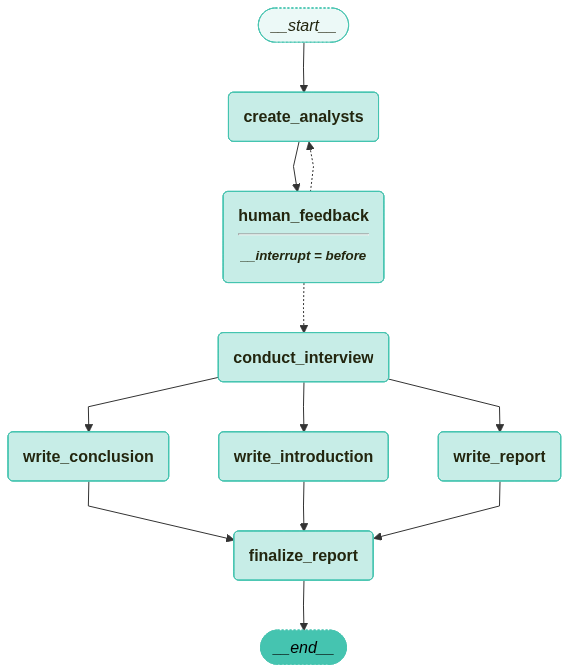

In [157]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

### 그래프 실행

In [158]:
from langchain_teddynote.messages import random_uuid

config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random_uuid()},
)

topic = "모듈형 RAG가 기존의 단순 RAG와 어떻게 다른지 설명하고, 이를 생산 단계에서 활용할 때의 이점을 제시하십시오."
inputs = {"topic": topic, "max_analysts": 3}
invoke_graph(graph, inputs, config)



🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Tech Research Institute' name='Dr. Hana Kim' role='AI System Architect' description='Expert in AI architectures and knowledge integration. Focuses on how modular RAG improves adaptability and scalability compared to traditional monolithic RAG systems, especially in production environments.'
affiliation='Innovative AI Labs' name='Jinwoo Park' role='Data Scientist' description='Specializes in real-world AI deployment and performance optimization. Analyzes the practical benefits of modular RAG for maintainability, updating knowledge bases, and system robustness in production.'
affiliation='NextGen AI Solutions' name='Mina Lee' role='AI Product Manager' description='Leads AI product development with an emphasis on user experience and operational efficiency. Studies how modular RAG enhances flexibility and speed of response in production settings, enabling better product evolvability.'

🔄 Node: __inte

In [159]:
invoke_graph(graph, Command(update={"human_feedback": None}), config)

Task __input__ with path () wrote to unknown channel human_feedback, ignoring it.



🔄 Node: human_feedback 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: generate_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_web in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: generate_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_arxiv in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_arxiv in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_web in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: generate_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_arxiv in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_web in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: generate_answer in [con

In [160]:
from IPython.display import Markdown

final_state = graph.get_state(config)
report = final_state.values.get("final_report")
display(Markdown(report))

# 모듈형 RAG와 기존 단순 RAG의 차별성 및 생산 단계 활용 이점  

## 서론(Introduction)  

현대 AI 기반 정보 처리 시스템에서 Retrieval-Augmented Generation(RAG)은 대규모 언어 모델(LLM)의 한계를 극복하고 외부 지식을 효과적으로 통합하는 핵심 기술로 자리매김하고 있습니다. 초기 단순 RAG(Naive RAG)는 직관적이고 구현이 용이하나, 급변하는 시장 환경과 복잡한 쿼리 대응에는 구조적 한계를 보이며 신속한 적응성과 세밀한 품질 관리가 어렵다는 제약점이 명확합니다. 이에 대해 모듈형 RAG(Modular RAG)는 RAG 시스템을 독립적이고 재조합 가능한 여러 모듈로 분해하여 유연성과 확장성을 극대화한 혁신적 아키텍처를 제안합니다.  

본 보고서는 모듈형 RAG가 단순 RAG와 대비하여 어떻게 구조적으로 차별화되는지 상세히 분석하고, 생산 현장에 도입할 때 나타나는 실질적 장점들을 조명합니다. 특히 스타트업과 같은 민첩한 조직에서 모듈형 RAG가 제공하는 기능적 유연성, 잡음 저감으로 인한 품질 향상, 다단계 추론 지원 능력 강화 등이 비즈니스 모델 혁신 및 시장 적응력 제고에 어떻게 기여할 수 있는지 심층적으로 살펴봅니다. 이로써 모듈형 RAG가 AI 기반 서비스 개발과 운영에 있어 필수적인 혁신 수단으로 자리매김할 가능성을 제시하고자 합니다.

---

## 주요 아이디어

## 인사이트

### 배경  
Retrieval-Augmented Generation(RAG)은 대규모 언어 모델(LLM)이 외부 지식을 활용해 정확하고 신뢰성 높은 텍스트를 생성하도록 지원하는 혁신적 기술이다. 전통적 Naive RAG는 문서 인덱싱, 검색, 생성 단계를 일관된 선형 파이프라인상에서 처리한다. 이 단순 구조는 초기 도입과 구현이 용이하나, 복잡한 쿼리 처리, 잡음 데이터 관리, 도메인별 맞춤형 대응 등에서 한계가 뚜렷하다[1][4][6]. 특히 쿼리와 문서 간 의미적 연관성을 심층 해석하지 못하고, 다수의 중복 혹은 비관련 문서가 LLM 생성 과정에 혼입돼 결과 왜곡 가능성을 높인다. 또한, 단일 파이프라인 설계는 신규 기술 적용이나 특정 모듈 교체 시 전체 시스템 재설계 및 재훈련이라는 높은 비용과 시간 투자 부담을 낳는다. 이러한 한계는 산업현장, 스타트업, 복잡 도메인에서 고품질 AI 응답과 민첩한 시장 대응 요구에 부합하지 못하는 주요 요인이다.  
이와 달리 Modular RAG는 시스템을 독립적인 기능별 모듈들로 분해해 검색기, 생성기, 라우팅, 스케줄링, 재순위화 모듈 등으로 구성한다. 레고 블록처럼 각 모듈을 교체, 추가, 재조합할 수 있어 시스템 유연성과 유지보수 효율성이 크게 향상된다[1][4][5]. 또한, 조건분기, 반복 루프 등 비선형 처리 흐름 지원으로 복잡한 다단계 추론 및 다중 문서 참조가 가능해져 고도화된 쿼리 응답력이 증대된다. 이와 같은 구조적 혁신은 스타트업과 빠른 시장 변화를 겪는 기업에 반드시 요구되는 민첩성과 맞춤형 대응력을 동시에 제공한다.

### 방법론  
모듈형 RAG는 Naive RAG의 선형 파이프라인을 대체한다. 개별 기능은 검색기, 임베딩, 라우팅 및 스케줄링, 문서 필터링과 재순위화, 생성기로 세분화되어 각 모듈은 독립적으로 개발, 평가, 교체가 가능하다.  
이 중 라우팅 및 스케줄링 모듈은 동적 경로 설정, 조건 분기, 반복 루프 등 복잡한 정보 흐름을 구성하며, 퓨전 메커니즘으로 다중 데이터 소스와 모듈 간 정보 융합을 지원한다[1]. 각 모듈별 고도화로 잡음 제거, 중복 데이터 필터링, 정보 압축 등 품질관리 작업을 수행해 LLM에 투입되는 입력 품질을 극대화한다. 결과적으로 다단계 추론, 복잡 쿼리 대응, 고신뢰성 출력 생성이 가능하다.  
구현 관점에서는 Ollama 모델, Langchain, LangGraph 등 프레임워크를 통해 프로덕션 환경에 적합한 로컬화 배포도 가능하며, 이를 통해 저성능 환경에서도 안정적 성능을 보장할 수 있다[2]. 모듈 단위 유지보수와 업그레이드가 가능해 시스템 다운타임 없이 신속한 기능 추가 및 성능 개선이 이루어진다.

### 결과  
모듈형 RAG를 산업 현장에 적용한 사례로 자동차 산업 내 PDF 문서 처리 챗봇 개발이 있다. 이 사례는 복잡한 다중 컬럼 레이아웃과 방대한 규격 및 지침서 문서를 효율적으로 처리하기 위해 모듈별 맞춤 임베딩, 검색, 정보 압축, 재순위화 모듈을 설계하였다[2].  
평가 결과, 기존 Naive RAG 대비 컨텍스트 정밀도, 답변 정확도, 응답 적합성, 신뢰도 등 모든 주요 성능 지표에서 눈에 띄는 개선이 확인되었다. 특히, 잡음 제거 모듈과 동적 라우팅 설계가 복잡 쿼리 및 다중 문서 참조 추론에 효과적인 것으로 나타났다.  
또한 로컬 환경에 Ollama 모델을 배포해 인터넷 연결이 제한된 저성능 환경에서도 안정적인 성능을 유지하며, 신속한 유지보수와 확장 운영이 가능함을 실증하였다.  
이와 같은 생산 단계 적용 예시는 스타트업이 자체 기술 역량과 제한된 자원 내에서 고품질 AI 서비스를 빠르게 출시하고 고객 맞춤화 서비스를 제공하는 데 큰 도움을 준다.

### 시사점  
스타트업 및 신속한 비즈니스 환경에서는 민첩성과 유연성이 무엇보다 중요하다. 모듈형 RAG는 기존 Naive RAG 구조 대비 다음과 같은 전략적 이점을 제공한다:  
- **비즈니스 맞춤형 신속 개조**: 전면 재학습이나 대규모 개편 없이 특정 도메인별 모듈만 교체하거나 신설 가능, 시장 변화 대응 속도 향상[1][2].  
- **운영 비용 절감과 안정성 강화**: 모듈별 독립 업데이트로 다운타임 최소화, 유지보수 비용과 리스크 감소, 스타트업처럼 제한된 자원에서 효율적 운영 가능[2][5].  
- **복잡한 고객 요구 대응 및 차별화**: 조건 분기, 반복 처리 지원으로 보다 세밀하고 복합적인 비즈니스 프로세스 맞춤형 RAG 구축, 차별적 사용자 경험과 비즈니스 가치 창출[1].  
- **확장성 및 지속가능한 혁신 기반**: 신규 기능 모듈 추가, 다양한 RAG 구성 패턴(선형, 분기, 루프 등) 대응력 확보로 스타트업 성장 단계별 맞춤형 플랫폼 진화 가능[1][5].  
이와 같이 모듈형 RAG는 스타트업 창업자나 기술 리더가 지식집약형 AI 서비스를 신속히 설계·운영하고, 시장 요구에 민첩하고 효과적으로 대응할 수 있도록 지원하는 핵심 기술 인프라로 부상하고 있다.

---

## 출처  
[1] Yunfan Gao et al., “Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks”, arXiv:2407.21059v1, 2024, http://arxiv.org/abs/2407.21059v1  
[2] Yonghyun Lee et al., “Optimizing RAG Techniques for Automotive Industry PDF Chatbots: A Case Study with Locally Deployed Ollama Models”, arXiv:2408.05933v1, 2024, http://arxiv.org/abs/2408.05933v1  
[4] ADaSci, “How does Modular RAG improve upon Naive RAG?”, https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/  
[5] MeiliSearch, “Modular RAG: What it is, how it works, architecture & more”, https://www.meilisearch.com/blog/modular-rag  
[6] ADaSci, “How does Modular RAG improve upon Naive RAG?”, https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/

---

## 결론(Conclusion)

본 보고서에서는 전통적 단순 RAG와 대비되는 모듈형 RAG의 구조적 혁신과 생산 단계 적용의 이점을 심도 있게 분석하였다. 단순 RAG가 단일 선형 파이프라인으로 구현되어 복잡한 쿼리 처리와 품질 제어에 제한을 받는 반면, 모듈형 RAG는 검색, 생성, 라우팅, 정보 융합 등 핵심 기능을 독립 모듈로 분해함으로써 유연성과 확장성을 비약적으로 향상시킨다. 이러한 모듈화는 스타트업처럼 변화무쌍한 시장 환경에서 신속한 기술 교체와 맞춤형 응답 체계 구축을 가능케 하여 민첩한 비즈니스 모델 혁신을 지원한다.

특히 생산 환경에서 모듈형 RAG 도입은 운영비용 절감과 품질 고도화, 복잡한 다단계 추론 가능성 확대라는 중대한 이점을 제공한다. 자동차 산업 PDF 챗봇 사례와 같이, 실제 적용에서 효율적 문서처리 및 신뢰성 높은 응답 생성 성과를 통해 스타트업의 경쟁력 강화와 고객 맞춤형 서비스 구현을 뒷받침하는 유력한 기술임을 입증하였다.

결과적으로 모듈형 RAG는 기존 단순 RAG의 한계를 극복하며 기업가 정신과 신속한 혁신을 추구하는 스타트업에 필수적인 AI 인프라로 자리매김하고 있다. 향후 다양한 도구와 연구가 발전함에 따라, 이 기술은 보다 전문적이고 복잡한 도메인 과제를 해결하며 비즈니스 가치를 지속적으로 창출할 것이다.